In [69]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Concatenate
from scipy.interpolate import interp1d
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, multiply, Reshape, add
from keras.models import Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.applications import VGG19

In [70]:

img_height = 112
img_width = 112
batch_size = 32
data_dir = r"C:\Users\lixue\Desktop\archive\Dataset"
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
# 获取数据集的大小
dataset_size = len(ds)

# 计算划分的大小
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# 划分数据集
train_ds = ds.take(train_size)
remaining_ds = ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

# 确保每个数据集都有足够的样本
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 400 files belonging to 4 classes.


In [73]:
def accuracy(y_true, y_pred):
    # 计算预测正确的样本数量
    correct_predictions = tf.equal(y_pred, y_true)
    # 计算准确率
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy
def custom_loss(y_true, y_pred):
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.squeeze(y_true, axis=-1), 4)

    # Convert predicted values to probability distribution
    y_pred = tf.nn.softmax(y_pred)

    # Extract the probabilities of the correct class
    batch_size = tf.shape(y_true_one_hot)[0]
    batch_range = tf.range(0, batch_size, dtype=tf.int64)

    # Use tf.argmax without one-hot encoding to get the correct class indices
    true_class_indices = tf.argmax(y_true_one_hot, axis=1)

    indices = tf.stack([batch_range, true_class_indices], axis=1)
    prob = tf.gather_nd(y_pred, indices)

    # Calculate negative log loss
    loss = -tf.math.log(prob + 1e-7)

    return tf.reduce_mean(loss)
model = VGG19(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
model.trainable = False
x = GlobalAveragePooling2D()(model.output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)
# 创建集成模型
ensemble_model = Model(inputs=model.input, outputs=output)

checkpoint_filepath = 'model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
# 编译模型
ensemble_model.compile(optimizer='adam', loss=custom_loss, metrics=accuracy)
start_time = time.time()
history = ensemble_model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/50
10/10 [==============================] - 24s 425ms/step - loss: 9.6212 - accuracy: 0.3562 - val_loss: 2.6833 - val_accuracy: 0.5938

Epoch 00001: val_accuracy improved from -inf to 0.59375, saving model to model.h5
Epoch 2/50
10/10 [==============================] - 3s 257ms/step - loss: 3.2100 - accuracy: 0.6531 - val_loss: 1.6523 - val_accuracy: 0.7188

Epoch 00002: val_accuracy improved from 0.59375 to 0.71875, saving model to model.h5
Epoch 3/50
10/10 [==============================] - 3s 263ms/step - loss: 1.9459 - accuracy: 0.7188 - val_loss: 0.9302 - val_accuracy: 0.7812

Epoch 00003: val_accuracy improved from 0.71875 to 0.78125, saving model to model.h5
Epoch 4/50
10/10 [==============================] - 3s 254ms/step - loss: 1.2716 - accuracy: 0.7656 - val_loss: 0.3354 - val_accuracy: 0.8750

Epoch 00004: val_accuracy improved from 0.78125 to 0.87500, saving model to model.h5
Epoch 5/50
10/10 [==============================] - 3s 255ms/step - loss: 0.6626 - accurac

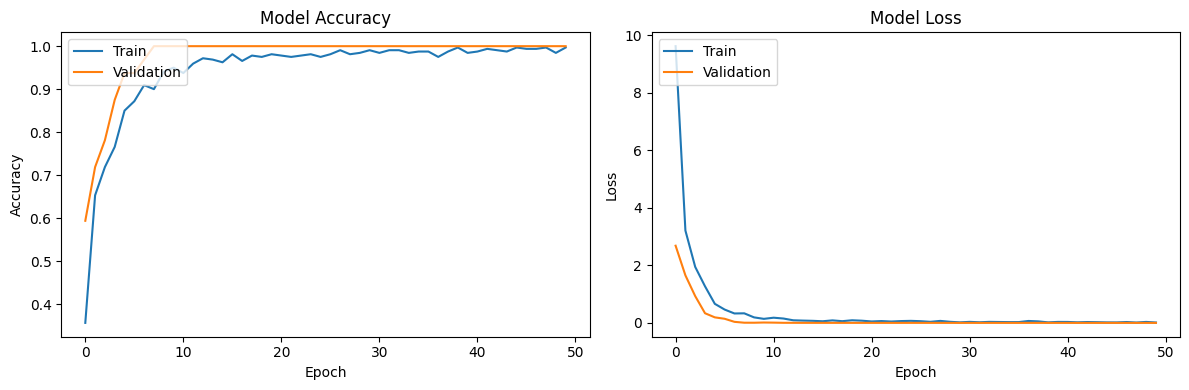

2/2 [==============================] - 16s 14s/step - loss: 0.0048 - accuracy: 1.0000


In [74]:
# Plot training and validation accuracy curves
plt.figure(figsize=(12, 4))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

end_time = time.time()
training_time = end_time - start_time
# 打印模型概要
best_model = keras.models.load_model(checkpoint_filepath)
# 在测试集上评估模型
test_loss, _ = best_model.evaluate(test_ds)

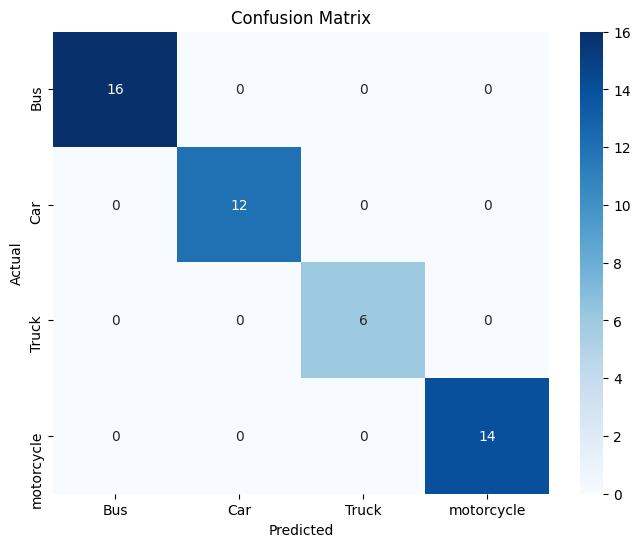

In [76]:
# 获取测试集的真实标签和预测标签
true_labels = []
predicted_labels = []
predicted_probs = []
for images, labels in test_ds:
    predictions = best_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    predicted_probs.extend(predictions)
    true_labels.extend(labels.numpy())

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, predicted_labels)

# 使用Seaborn绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=ds.class_names, yticklabels=ds.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

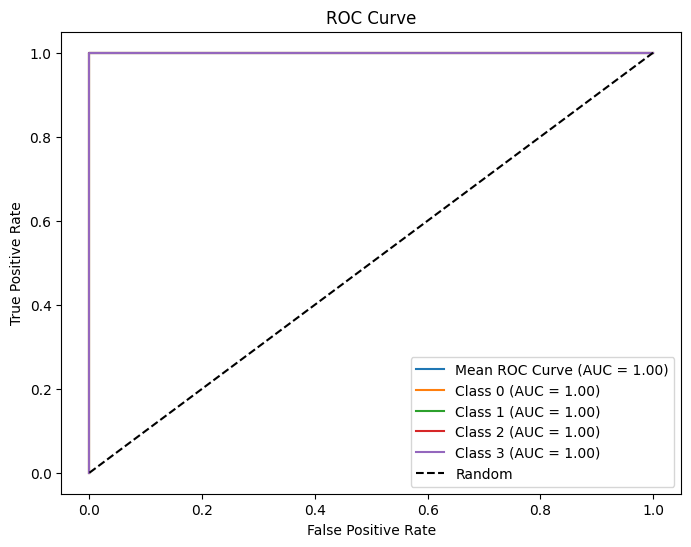

In [77]:
# Convert true labels to one-hot encoding for AUC calculation
true_labels_one_hot = tf.keras.utils.to_categorical(true_labels, num_classes=4)

# Convert predicted_probs to NumPy array
predicted_probs = np.array(predicted_probs)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Calculate the average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Interpolate ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= 4
mean_roc_auc = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, label=f'Mean ROC Curve (AUC = {mean_roc_auc:.2f})')
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

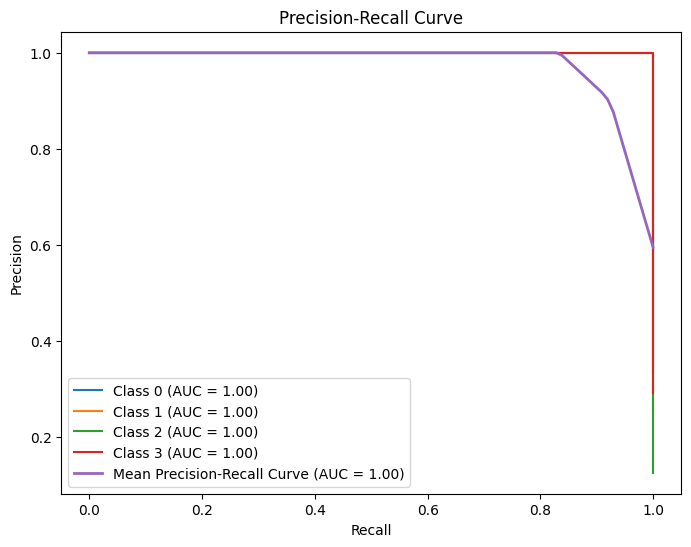

In [78]:
# Calculate precision-recall curve and AUC for each class
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    pr_auc[i] = average_precision_score(true_labels_one_hot[:, i], predicted_probs[:, i])

# Calculate the average precision-recall curve
# Calculate the average precision-recall curve
all_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(all_recall)
for i in range(4):
    # Interpolate precision values to have the same length
    interp_precision = interp1d(recall[i], precision[i], kind='linear', fill_value='extrapolate')
    interp_precision_values = interp_precision(all_recall)
    mean_precision += interp_precision_values

# Average and compute AUC
mean_precision /= 4
mean_pr_auc = average_precision_score(true_labels_one_hot, predicted_probs)


# Plot precision-recall curves
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')
plt.plot(all_recall, mean_precision, label=f'Mean Precision-Recall Curve (AUC = {mean_pr_auc:.2f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [79]:
# Calculate additional metrics
roc_auc = np.mean(list(roc_auc.values()))
pr_auc = np.mean(list(pr_auc.values()))
report = classification_report(true_labels, predicted_labels)
test_accuracy= accuracy(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_mat = confusion_matrix(true_labels, predicted_labels)
# Calculate sensitivity and specificity for each class
class_sensitivity = []
class_specificity = []
for i in range(conf_mat.shape[0]):
    tp = conf_mat[i, i]  # True Positive
    tn = np.sum(np.delete(np.delete(conf_mat, i, axis=0), i, axis=1))  # True Negative
    fp = np.sum(conf_mat[:, i]) - tp  # False Positive
    fn = np.sum(conf_mat[i, :]) - tp  # False Negative

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    class_sensitivity.append(sensitivity)
    class_specificity.append(specificity)

# Calculate macro-average sensitivity and specificity
macro_sensitivity = np.mean(class_sensitivity)
macro_specificity = np.mean(class_specificity)


# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f"Training time: {training_time:.2f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'roc_auc: {roc_auc:.4f}')
print(f'pr_auc: {pr_auc:.4f}')
print('Confusion Matrix:')
print(conf_mat)
print(f'Sensitivity: {macro_sensitivity:.4f}')
print(f'Specificity: {macro_specificity:.4f}')
print(report)

Test Loss: 0.0048
Test Accuracy: 100.00%
Training time: 154.83 seconds
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
roc_auc: 1.0000
pr_auc: 1.0000
Confusion Matrix:
[[16  0  0  0]
 [ 0 12  0  0]
 [ 0  0  6  0]
 [ 0  0  0 14]]
Sensitivity: 1.0000
Specificity: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        14

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

